# Project Description & Datasets

[I’m Something of a Painter Myself](https://www.kaggle.com/competitions/gan-getting-started/data)
### Brief description of the problem, NLP and data

In this project, we will use Generative Adversarial Networks (GANs) to generate Monet-style paintings. The challenge involves training a GAN model on a dataset of Monet paintings, aiming to create new, visually convincing images in Monet's distinctive style. GANs consist of two neural networks: a generator that creates images and a discriminator that evaluates them. The Monet Painting Dataset from Kaggle contains images of Monet's works, structured as 3D tensors representing pixel values across RGB channels.

**Data Overview:**
- **Size**: Approximately 300 Monet paintings.
- **Dimension**: Each image is typically 256x256 pixels, with three color channels (RGB).
- **Structure**: Images are stored in JPEG format, with a consistent resolution and color depth.



**Data Overview & Structure**:

The dataset has two key files: train.csv (7613 rows) and test.csv (3263 rows). It contains approximately 10,000 tweets labeled as either related to disasters or not. Each row in the dataset includes columns such as id, text (the tweet), location, keyword, and target (the label). The data needs to be pre-processed to handle missing values, stop words, and other inconsistencies before model building.

**Competition Description from Kaggle**:

"This particular challenge is perfect for data scientists looking to get started with Natural Language Processing. The competition dataset is not too big, and even if you don’t have much personal computing power, you can do all of the work in our free, no-setup, Jupyter Notebooks environment called Kaggle Notebooks."


#### Files
train.csv - the training set \ 
test.csv - the test set \
sample_submission.csv - a sample submission file in the correct format\

#### Columns
- `id` - a unique identifier for each tweet
- `text` - the text of the tweet
- `location` - the location the tweet was sent from (may be blank)
- `keyword` - a particular keyword from the tweet (may be blank)
- `target` - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

# Import Packages & Datasets

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow import keras

from glob import glob
import cv2

# other
import requests
from tqdm import tqdm,trange
import gc #garbage collection, we need to save all the RAM we can
import logging
import random
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)




### Steps

1. **Image Loading and Preprocessing**:
   - Images are loaded and resized to a consistent shape of 256x256 pixels. They are converted to RGB mode to ensure consistency.

2. **Sample Image Visualization**:
   - The `plot_sample_images` function visualizes a few images from both the Monet and Photo datasets, providing a quick overview.

3. **Pixel Intensity Distribution**:
   - Pixel intensity distributions for Monet and Photo images are plotted to understand the range and frequency of pixel values. This can give insights into the overall brightness and contrast of the images.

4. **Data Cleaning**:
   - The `check_image_integrity` function is used to identify corrupted images that cannot be opened or processed. Such images are removed from the dataset.

5. **Metrics and Visualization After Cleaning**:
   - After cleaning, the dataset is reloaded, and the images are visualized again to ensure everything is in order.

In [82]:
# packages versions
!pip freeze

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


absl-py==2.1.0
annotated-types==0.7.0
anyio @ file:///private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_a17a7759g2/croot/anyio_1706220182417/work
appnope @ file:///Users/cbousseau/work/recipes/ci_py311/appnope_1677917710869/work
argon2-cffi @ file:///opt/conda/conda-bld/argon2-cffi_1645000214183/work
argon2-cffi-bindings @ file:///Users/cbousseau/work/recipes/ci_py311/argon2-cffi-bindings_1677915727169/work
asttokens @ file:///opt/conda/conda-bld/asttokens_1646925590279/work
astunparse==1.6.3
async-lru @ file:///private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_02efro5ps8/croot/async-lru_1699554529181/work
attrs @ file:///private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_224434dqzl/croot/attrs_1695717839274/work
audioread==3.0.1
Babel @ file:///Users/cbousseau/work/recipes/ci_py311/babel_1677920677615/work
beautifulsoup4 @ file:///private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_94rx5n7wo9/croot/beautifulsoup4-split_1718029832430/work
bidict==0.

In [2]:
# directories
monet_dir = 'monet_jpg/'
photo_dir = 'photo_jpg/'

In [3]:
# Function to load images and convert them to numpy arrays
def load_images(filenames, target_size=(256, 256)):
    images = []
    for f in filenames:
        img = Image.open(f).convert('RGB')  # Ensure images are in RGB mode
        img = img.resize(target_size)  # Resize images to a consistent size
        images.append(np.array(img))
    return np.array(images)

# Retrieve filenames for Monet and photo images
monet_filenames = [os.path.join(monet_dir, f) for f in os.listdir(monet_dir) if os.path.isfile(os.path.join(monet_dir, f))]
photo_filenames = [os.path.join(photo_dir, f) for f in os.listdir(photo_dir) if os.path.isfile(os.path.join(photo_dir, f))]

# Load and preprocess images
monet_images = load_images(monet_filenames)
photo_images = load_images(photo_filenames)

# Some basic metrics
print(f"Number of Monet images: {len(monet_images)}")
print(f"Number of Photo images: {len(photo_images)}")
if len(monet_images) > 0:
    print(f"Image shape: {monet_images[0].shape}")

Number of Monet images: 300
Number of Photo images: 7038
Image shape: (256, 256, 3)


# Data Cleaning & Exploratory Data Analysis (EDA)

In this step, we will conduct a thorough analysis of the dataset to understand its characteristics. This includes visualizing the distribution of pixel values across different images and identifying any anomalies or inconsistencies. 

**Tasks:**
- **Visualizations**: Create histograms of pixel intensities and display a grid of sample images to get an overview of the dataset.
- **Data Cleaning**: If necessary, resize images to a uniform size, normalize pixel values, and handle any missing or corrupted files.

**Plan of Analysis**:
Based on the EDA, the analysis will focus on optimizing the GAN architecture to effectively capture the style of Monet's paintings. We will experiment with different generator and discriminator architectures to determine which configuration produces the most convincing results.


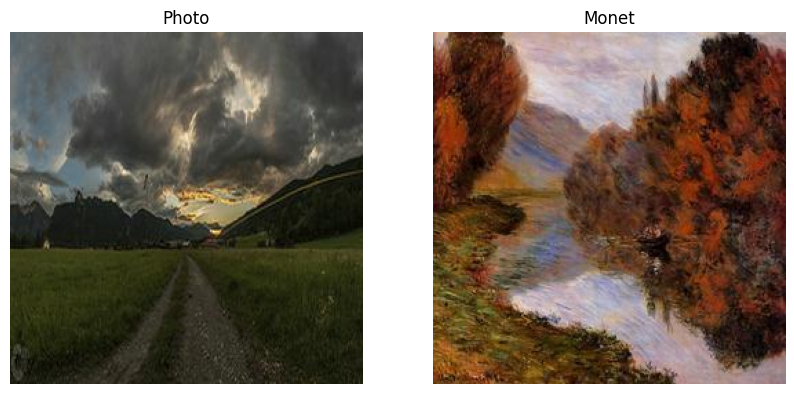

In [11]:
# Let's print some examples
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.title('Photo')
plt.imshow(photo_files[42])  # Use loaded array instead of reloading the image
plt.axis('off')

plt.subplot(122)
plt.title('Monet')
plt.imshow(monet_files[42])  # Use loaded array instead of reloading the image
plt.axis('off')

plt.show()

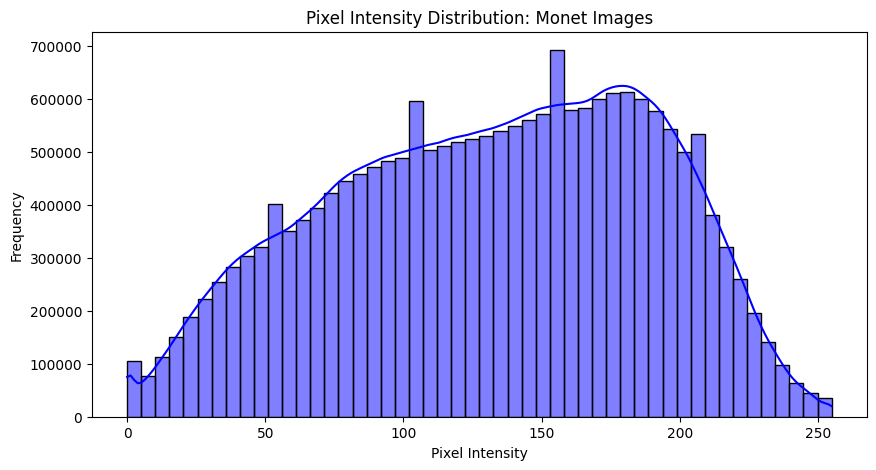

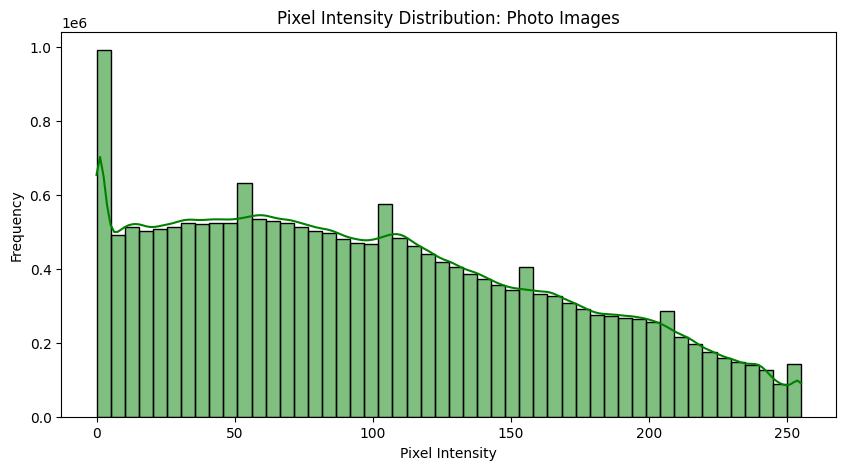

In [7]:
# Use a Subset of Images
# Instead of plotting the distribution for all images, you can select a smaller subset. This can drastically reduce memory usage.
# Use a subset of images for plotting
subset_size = 100  # Adjust as needed
monet_subset = monet_images[:subset_size]
photo_subset = photo_images[:subset_size]

plot_pixel_distribution(monet_subset, 'Monet Images', 'blue')
plot_pixel_distribution(photo_subset, 'Photo Images', 'green')

### EDA Insights:

### Monet Images:
- **Balanced Intensities:** The distribution is bell-shaped, with peaks in the mid-range (100-150), indicating a balanced use of light and color.
- **Fewer Extremes:** There are fewer very dark or bright areas, reflecting Monet’s subtle blending of tones.

### Photo Images:
- **Dark Areas:** A strong peak at low intensities (near 0) suggests frequent dark regions, typical of real-world shadows.
- **Wider Range:** The distribution is more skewed towards darker tones, with fewer bright areas.

### Interpretation:
- **Artistic vs. Real:** Monet’s paintings have smoother, more balanced light and color, while photos capture more extreme contrasts, including dark shadows.
- **Use of Light:** Monet's style avoids extremes, unlike the natural diversity in photos.

This comparison highlights the controlled use of light in art versus the variability in real scenes.

- **Pixel Intensity Distribution**: Helps in understanding the distribution of pixel values across the images, which can influence model training.
- **Data Cleaning**: Ensures that the dataset is free from corrupted files and that all images are consistent in size and color format.

This EDA and data cleaning step prepares the dataset for further processing, modeling, and analysis, ensuring a clean and consistent input for the GAN models.

In [10]:
# Data Cleaning: Check for corrupted images or outliers
def check_image_integrity(filenames):
    corrupted = []
    for f in filenames:
        try:
            img = Image.open(f)
            img.verify()  # Check if the image can be opened
        except (IOError, SyntaxError) as e:
            corrupted.append(f)
    return corrupted

# Identify corrupted images
corrupted_monet = check_image_integrity(monet_filenames)
corrupted_photo = check_image_integrity(photo_filenames)

print(f"Corrupted Monet images: {len(corrupted_monet)}")
print(f"Corrupted Photo images: {len(corrupted_photo)}")

# Remove corrupted images from the dataset
monet_filenames = [f for f in monet_filenames if f not in corrupted_monet]
photo_filenames = [f for f in photo_filenames if f not in corrupted_photo]

# Reload images after cleaning
monet_images = load_images(monet_filenames)
photo_images = load_images(photo_filenames)

# Updated metrics after cleaning
print(f"Number of Monet images after cleaning: {len(monet_images)}")
print(f"Number of Photo images after cleaning: {len(photo_images)}")

Corrupted Monet images: 0
Corrupted Photo images: 0
Number of Monet images after cleaning: 300
Number of Photo images after cleaning: 7038


## Preprocess 

### Data Balancing and Splitting

1. **Balancing the Dataset**: Ensure that the dataset has an equal number of Monet and photo images. If the datasets are imbalanced, we can either undersample the larger class or oversample the smaller class.

2. **Train-Test Split**: Once the dataset is balanced, split it into training and testing sets using an 80/20 split.

### Explanation:

1. **Balancing the Dataset**:
   - The dataset is balanced by selecting the same number of images from both Monet and Photo categories.
   - `np.random.choice` is used to randomly sample images from the larger dataset to match the size of the smaller dataset.

2. **Combining and Shuffling**:
   - The Monet and Photo images are combined into a single dataset `X`, and their labels are stored in `y`.
   - The dataset is shuffled to mix the Monet and Photo images, ensuring the train-test split isn't biased.

3. **Train-Test Split**:
   - An 80/20 split is performed using `train_test_split` from scikit-learn, which divides the dataset into training and testing sets.
   - The `stratify=y` parameter ensures that the class distribution remains consistent in both the training and testing sets.

4. **Output**:
   - The shapes and label distributions of the training and testing sets are printed to verify the split.
   - A visualization of a few training and testing samples is provided for visual verification.

### Objective:
This preprocessing step ensures that the dataset is balanced and appropriately split into training and testing sets, which is crucial for building reliable GAN models that can generalize well to unseen data.

In [19]:
# Balance the Dataset
# If the two classes (Monet and Photos) have different sizes, balance them by undersampling
monet_images = load_images(monet_filenames)
photo_images = load_images(photo_filenames)

# Determine the minimum number of images between the two classes
min_samples = min(len(monet_images), len(photo_images))

# Randomly sample indices to balance the dataset
monet_indices = np.random.choice(len(monet_images), min_samples, replace=False)
photo_indices = np.random.choice(len(photo_images), min_samples, replace=False)

# Select the images based on the sampled indices
balanced_monet_images = monet_images[monet_indices]
balanced_photo_images = photo_images[photo_indices]

# Create labels for the images (1 for Monet, 0 for Photos)
monet_labels = np.ones(len(balanced_monet_images))
photo_labels = np.zeros(len(balanced_photo_images))

# Combine Monet and Photo images and their labels
X = np.concatenate([balanced_monet_images, balanced_photo_images], axis=0)
y = np.concatenate([monet_labels, photo_labels], axis=0)

# Shuffle the dataset to mix Monet and Photo images
indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# Train-Test Split: 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Output the shapes of the training and testing sets
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Training set labels distribution: {np.bincount(y_train.astype(int))}")
print(f"Testing set labels distribution: {np.bincount(y_test.astype(int))}")

Training set size: 480 samples
Testing set size: 120 samples
Training set labels distribution: [240 240]
Testing set labels distribution: [60 60]


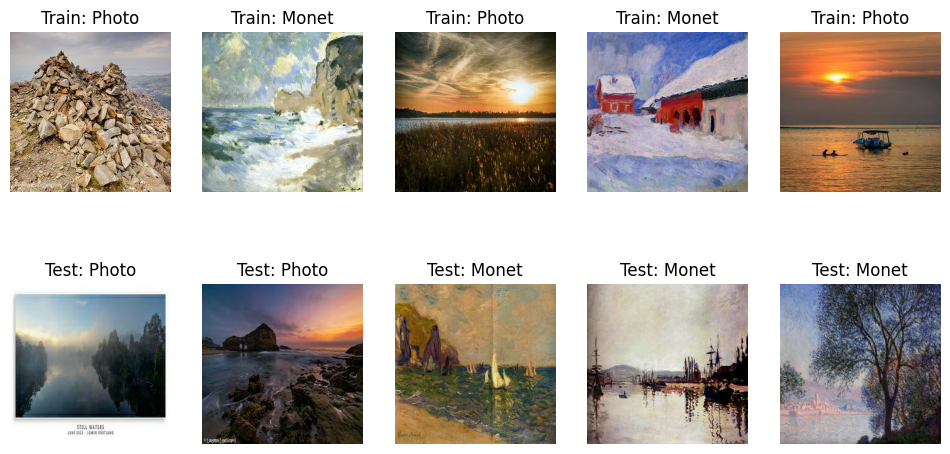

In [20]:
def plot_train_test_samples(X_train, X_test, y_train, y_test):
    plt.figure(figsize=(12, 6))
    
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.title(f'Train: {"Monet" if y_train[i] else "Photo"}')
        plt.imshow(X_train[i])  # Assuming images are now in [0, 1]
        plt.axis('off')

    for i in range(5):
        plt.subplot(2, 5, i + 6)
        plt.title(f'Test: {"Monet" if y_test[i] else "Photo"}')
        plt.imshow(X_test[i])  # Assuming images are now in [0, 1]
        plt.axis('off')
    
    plt.show()


# Visualize a few samples from the training and testing sets
plot_train_test_samples(X_train, X_test, y_train, y_test)

# Building and training models

We will design three different GAN architectures, each with varying complexity and strategies for image generation.

**Model 1: Basic GAN**
- **Architecture**: A simple GAN with a basic generator and discriminator. The generator will consist of a series of transposed convolutional layers, while the discriminator will use standard convolutional layers to classify images as real or fake.
- **Reasoning**: This model serves as a baseline to understand the fundamental workings of GANs on this dataset.

**Model 3: Conditional GAN (cGAN)**
- **Architecture**: A conditional GAN where the generator and discriminator are conditioned on additional information, such as image style or content. This model will incorporate conditioning on specific Monet painting characteristics.
- **Reasoning**: By providing more context, the model can learn to generate more stylistically accurate images, potentially leading to higher quality outputs.



### Model 1 Architecture - RNN

The `train` function is designed to train a GAN, consisting of a generator and a discriminator, on image data. Here's a brief breakdown:

1. **Setup:**
   - Real images (`valid` labels as 1s) and fake images (`fake` labels as 0s) are prepared.
   - The generator creates fake images from random noise, while the discriminator learns to distinguish between real and fake images.

2. **Training Loop:**
   - **Discriminator:** 
     - Real images are resized and fed into the discriminator.
     - Fake images are generated by the generator.
     - The discriminator is trained on both real and fake images, and its loss is calculated.
   - **Generator:** 
     - The generator is trained to produce images that can fool the discriminator into classifying them as real.
   
3. **Progress Logging:**
   - At regular intervals, the function prints the losses for both the discriminator and generator and displays sample images generated by the generator. 

This loop continues for a specified number of epochs, improving the quality of generated images over time.

In [4]:
# monet_path = 'monet_jpg/*.jpg'
# monet_images = load_images(monet_path)

# Normalize pixel values to [-1, 1]
monet_images = (monet_images - 127.5) / 127.5

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
0 [D loss: 0.7022779583930969] [G loss: [array(0.69917023, dtype=float32), array(0.69917023, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


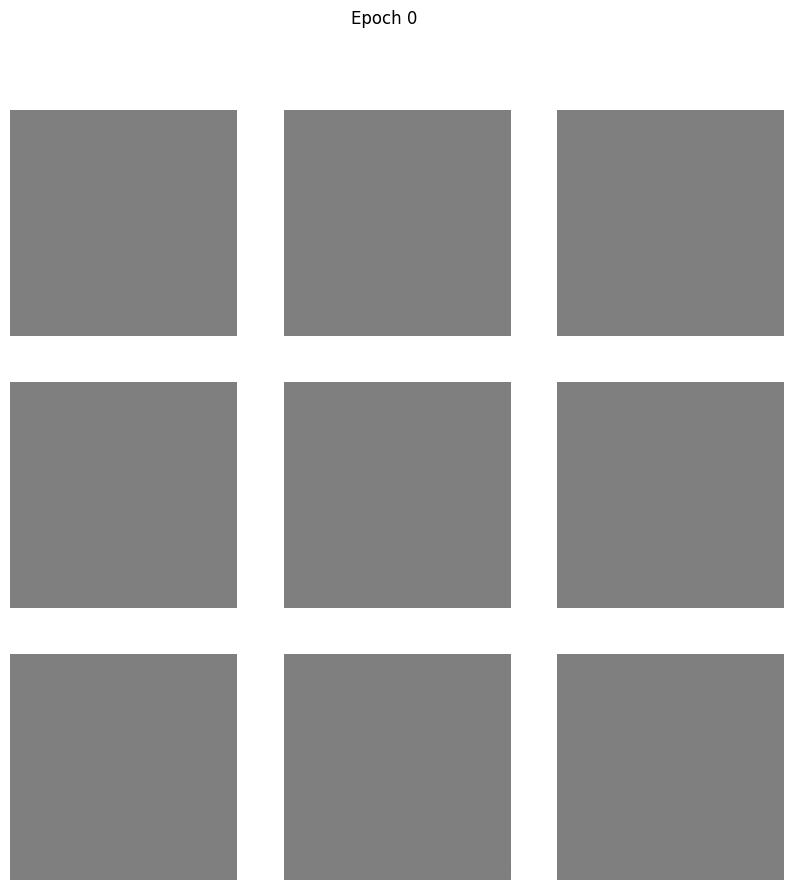

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


KeyboardInterrupt: 

In [7]:
# Step 3: Model 1 - Basic GAN

def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(256 * 16 * 16, input_shape=(100,)),
        layers.Reshape((16, 16, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='tanh')
    ])
    return model


def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[256, 256, 3]),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Define the GAN class
class GAN:
    def __init__(self):
        self.generator = build_generator()
        self.discriminator = build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))
        
        z = layers.Input(shape=(100,))
        img = self.generator(z)
        
        self.discriminator.trainable = False
        valid = self.discriminator(img)
        
        self.combined = tf.keras.Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))

# Instantiate the GAN
gan = GAN()

# Step 4: Training the GAN

def train(gan, data, epochs=10000, batch_size=32, sample_interval=1000):
    X_train = data
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for epoch in range(epochs):
        # Train discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = gan.generator.predict(noise)
        
        d_loss_real = gan.discriminator.train_on_batch(imgs, valid)
        d_loss_fake = gan.discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Train generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.combined.train_on_batch(noise, valid)
        
        # Print progress
        if epoch % sample_interval == 0:
            print(f"{epoch} [D loss: {d_loss}] [G loss: {g_loss}]")
            sample_images(gan.generator, epoch)

def sample_images(generator, epoch=0):
    noise = np.random.normal(0, 1, (9, 100))
    gen_imgs = generator.predict(noise)
    
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow((gen_imgs[i] + 1) / 2)  # Rescale back to [0, 1]
        plt.axis('off')
    plt.suptitle(f"Epoch {epoch}")
    plt.show()


# Train the model
train(gan, monet_images, epochs=10000, batch_size=32, sample_interval=1000)

In [19]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [25]:
# Number of channels in the output image
NUM_CHANNELS = 3



# Custom InstanceNormalization class
class InstanceNormalization(layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(shape=(input_shape[-1],),
                                     initializer='ones', trainable=True)
        self.beta = self.add_weight(shape=(input_shape[-1],),
                                    initializer='zeros', trainable=True)
        super(InstanceNormalization, self).build(input_shape)

    def call(self, inputs, training=False):
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        return tf.nn.batch_normalization(inputs, mean, variance, self.beta, self.gamma, self.epsilon)

# Function to reduce the image size
def reduce_image_size(filters, size, use_instancenorm=True):
    init = tf.random_normal_initializer(0., 0.02)

    model = tf.keras.Sequential()
    model.add(layers.Conv2D(filters, size, strides=2, padding='same',
                            kernel_initializer=init, use_bias=False))

    if use_instancenorm:
        model.add(InstanceNormalization())

    model.add(layers.LeakyReLU())

    return model

# Function to augment the image size
def augment_image_size(filters, size, add_dropout=False):
    init = tf.random_normal_initializer(0., 0.02)

    model = tf.keras.Sequential()
    model.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=init,
                                      use_bias=False))

    model.add(InstanceNormalization())

    if add_dropout:
        model.add(layers.Dropout(0.5))

    model.add(layers.ReLU())

    return model

# Function to generate new images
def ImageGenerator():
    input_layer = layers.Input(shape=[256, 256, 3])

    # Downsampling layers
    down_layers = [
        reduce_image_size(64, 4, use_instancenorm=False),
        reduce_image_size(128, 4),
        reduce_image_size(256, 4),
        reduce_image_size(512, 4),
        reduce_image_size(512, 4),
        reduce_image_size(512, 4),
        reduce_image_size(512, 4),
        reduce_image_size(512, 4),
    ]

    # Upsampling layers
    up_layers = [
        augment_image_size(512, 4, add_dropout=True),
        augment_image_size(512, 4, add_dropout=True),
        augment_image_size(512, 4, add_dropout=True),
        augment_image_size(512, 4),
        augment_image_size(256, 4),
        augment_image_size(128, 4),
        augment_image_size(64, 4),
    ]

    init = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2,
                                  padding='same',
                                  kernel_initializer=init,
                                  activation='tanh')

    x = input_layer

    # Downsampling through the model
    skips = []
    for down in down_layers:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_layers, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=input_layer, outputs=x)

# Function to determine if an image is real or fake
def ImageDiscriminator():
    init = tf.random_normal_initializer(0., 0.02)

    input_layer = layers.Input(shape=[256, 256, 3])

    x = input_layer

    down1 = reduce_image_size(64, 4, use_instancenorm=False)(x)
    down2 = reduce_image_size(128, 4)(down1)
    down3 = reduce_image_size(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=init,
                         use_bias=False)(zero_pad1)

    norm1 = InstanceNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=init)(zero_pad2)

    return tf.keras.Model(inputs=input_layer, outputs=last)


# Instantiate the generator and discriminator models
gen_monet = ImageGenerator()
gen_photo = ImageGenerator()

disc_monet = ImageDiscriminator()
disc_photo = ImageDiscriminator()

# Define the CycleGAN model linking generators and discriminators
class ArtCycleGan(keras.Model):
    def __init__(self, gen_monet, gen_photo, disc_monet, disc_photo, lambda_cycle=10):
        super(ArtCycleGan, self).__init__()
        self.gen_monet = gen_monet
        self.gen_photo = gen_photo
        self.disc_monet = disc_monet
        self.disc_photo = disc_photo
        self.lambda_cycle = lambda_cycle
        
    def compile(self, m_gen_optimizer, p_gen_optimizer, m_disc_optimizer, p_disc_optimizer,
                gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super(ArtCycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # Generate fake images and cycle images
            fake_monet = self.gen_monet(real_photo, training=True)
            cycled_photo = self.gen_photo(fake_monet, training=True)
            
            fake_photo = self.gen_photo(real_monet, training=True)
            cycled_monet = self.gen_monet(fake_photo, training=True)
            
            same_monet = self.gen_monet(real_monet, training=True)
            same_photo = self.gen_photo(real_photo, training=True)
    
            # Discriminator outputs
            disc_real_monet = self.disc_monet(real_monet, training=True)
            disc_real_photo = self.disc_photo(real_photo, training=True)
            
            disc_fake_monet = self.disc_monet(fake_monet, training=True)
            disc_fake_photo = self.disc_photo(fake_photo, training=True)
    
            # Calculate losses
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
            
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + \
                               self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
    
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + \
                                   self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + \
                                   self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
    
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)
    
        # Compute gradients
        monet_gen_grads = tape.gradient(total_monet_gen_loss, self.gen_monet.trainable_variables)
        photo_gen_grads = tape.gradient(total_photo_gen_loss, self.gen_photo.trainable_variables)
        monet_disc_grads = tape.gradient(monet_disc_loss, self.disc_monet.trainable_variables)
        photo_disc_grads = tape.gradient(photo_disc_loss, self.disc_photo.trainable_variables)
    
        # Apply gradients
        self.gen_monet_optimizer.apply_gradients(zip(monet_gen_grads, self.gen_monet.trainable_variables))
        self.gen_photo_optimizer.apply_gradients(zip(photo_gen_grads, self.gen_photo.trainable_variables))
        self.disc_monet_optimizer.apply_gradients(zip(monet_disc_grads, self.disc_monet.trainable_variables))
        self.disc_photo_optimizer.apply_gradients(zip(photo_disc_grads, self.disc_photo.trainable_variables))
    
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }




In [26]:
# Loss function for the discriminator
def discriminator_cost(real_output, generated_output):
    real_cost = tf.keras.losses.BinaryCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.NONE
    )(tf.ones_like(real_output), real_output)
    
    fake_cost = tf.keras.losses.BinaryCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.NONE
    )(tf.zeros_like(generated_output), generated_output)
    
    total_discriminator_cost = real_cost + fake_cost
    
    return total_discriminator_cost * 0.5

# Loss function for the generator
def generator_cost(generated_output):
    return tf.keras.losses.BinaryCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.NONE
    )(tf.ones_like(generated_output), generated_output)

# Loss for cycle consistency
def compute_cycle_loss(original_image, cycled_image, lambda_weight):
    cycle_loss_value = tf.reduce_mean(tf.abs(original_image - cycled_image))
    return lambda_weight * cycle_loss_value

# Loss for identity
def identity_cost(original_image, identical_image, lambda_weight):
    identity_loss_value = tf.reduce_mean(tf.abs(original_image - identical_image))
    return lambda_weight * 0.5 * identity_loss_value


In [27]:
# 3.5/ Train the CycleGAN
# Initialize optimizers
monet_gen_opt = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)
photo_gen_opt = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)

monet_disc_opt = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)
photo_disc_opt = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)

# Instantiate the model
# Instantiate the model with the correct argument names
cycle_gan = ArtCycleGan(
    gen_monet=monet_gen_opt, 
    gen_photo=photo_gen_opt, 
    disc_monet=monet_disc_opt, 
    disc_photo=photo_disc_opt
)


# Compile the model
cycle_gan.compile(
    m_gen_optimizer=monet_gen_opt,
    p_gen_optimizer=photo_gen_opt,
    m_disc_optimizer=monet_disc_opt,
    p_disc_optimizer=photo_disc_opt,
    gen_loss_fn=generator_cost,
    disc_loss_fn=discriminator_cost,
    cycle_loss_fn=compute_cycle_loss,
    identity_loss_fn=identity_cost
)

# Train the model
cycle_gan.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=20
)


NameError: name 'monet_ds' is not defined

In [43]:
import matplotlib.pyplot as plt
import numpy as np

def display_comparison(generator, dataset, num_samples=5):
    """
    Display several results by comparing input images and generated images.

    Parameters:
    - generator: The image generator model.
    - dataset: The dataset containing input images.
    - num_samples: The number of samples to display.
    """
    # Create a grid of subplots
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, 12))
    
    for i, sample in enumerate(dataset.take(num_samples)):
        # Generate the output image from the input sample
        generated_image = generator(sample, training=False)[0].numpy()
        generated_image = (generated_image * 127.5 + 127.5).astype(np.uint8)
        
        # Convert the input image to a format suitable for display
        input_image = (sample[0] * 127.5 + 127.5).numpy().astype(np.uint8)

        # Display the images
        axes[i, 0].imshow(input_image)
        axes[i, 1].imshow(generated_image)
        axes[i, 0].set_title("Original Image")
        axes[i, 1].set_title("Generated Image")
        axes[i, 0].axis("off")
        axes[i, 1].axis("off")
    
    plt.tight_layout()
    plt.show()

# Example usage
display_comparison(monet_generator, photo_ds)


NameError: name 'photo_ds' is not defined

### Make Predictions and Create a submission files

In [78]:
# Model 3 - RNN
pred_create_submission(rnn_model_3, "submission_rnn_model_3")

102/102 [==============================] - 1s 4ms/step
Submission file created successfully.

target
0    2117
1    1146
Name: count, dtype: int64


## Results and Analyses








In [ ]:
# display several results
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

## Conclusion




# Reference

https://www.kaggle.com/competitions/gan-getting-started/data

https://www.coursera.org/learn/introduction-to-deep-learning-boulder/peer/CYeK4/week-5-gans